#### Загрузка библиотек и необходимых модулей

In [1]:
options(warn=-1)

In [2]:
suppressWarnings(library(dplyr))
suppressWarnings(library(readr))
suppressWarnings(library(ggplot2))
suppressWarnings(library(descr))
suppressWarnings(library(SDMTools))

In [4]:
suppressWarnings(library(lattice))
suppressWarnings(library(ggplot2))
suppressWarnings(library(caret))

In [5]:
print(list.files("data"))

[1] "churn_data.csv"       "online-Copy1.csv"     "online.csv"          
[4] "online12M.csv"        "salesData.csv"        "salesDataMon2To4.csv"


#### Загрузка и первичный анализ данных

In [6]:
churnData <- read.csv("data/churn_data.csv")
churnData %>% mutate_if(is.integer, as.factor) -> churnData
churnData$orderDate <- as.Date(churnData$orderDate,format="%Y-%m-%d")

In [7]:
str(churnData)

'data.frame':	45236 obs. of  22 variables:
 $ X                : Factor w/ 45236 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ID               : Factor w/ 45236 levels "1","3","5","7",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ orderDate        : Date, format: "2014-12-23" "2014-09-10" ...
 $ title            : Factor w/ 4 levels "Company","Mr",..: 2 2 2 2 2 2 2 3 1 2 ...
 $ newsletter       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 2 1 ...
 $ websiteDesign    : Factor w/ 3 levels "1","2","3": 2 1 1 3 3 1 1 2 2 2 ...
 $ paymentMethod    : Factor w/ 4 levels "Cash","Credit Card",..: 3 4 1 1 1 2 4 4 3 1 ...
 $ couponDiscount   : Factor w/ 2 levels "0","1": 2 1 1 1 1 2 1 1 2 1 ...
 $ purchaseValue    : Factor w/ 5 levels "1","2","3","4",..: 2 1 4 4 4 4 4 5 1 3 ...
 $ giftwrapping     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ throughAffiliate : Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 2 2 2 ...
 $ shippingFees     : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 2 1 ...
 $ d

# __Анализ и предотвращение оттока в интернет-маркетинге__

Отток клиентов (Churn Rate) является очень важным показателем, так как во всех сферах бизнеса существуют конкуренты, которые в любой момент могут предложить пользователям более выгодные условия. Если основной доход компании зависит от постоянных клиентов, то необходимо добиваться как снижения оттока клиентов. Предотвращение оттока это мера, которая гарантирует, что покупатель посетить интернет-магазин вновь. 

<pr>__Почему важен анализ и предотвращения оттока клиентов:__ 
* приобретение новых покупателей/пользователей намного дороже чем удержание существующих;

<pr>__Ключевой вопрос при анализе и предотвращении оттока клиентов:__ 
* каким образом отличить лояльных клиентов от тех кто совершит покупки толко один раз?

<pr>__Применение анализа оттока клиентов на практике:__ 
* убедить текущих клиентов быть лояльными и совершить покупку вновь.
* предотвращение оттока это мера, которая гарантирует, что покупатель посетить интернет-магазин вновь.

В данном кейсе для предсказания вероятности оттока клиентов была создана модель с использованием метода логистической регрессии. На основе данной модели с большой долей вероятности мы можем делать предсказания потеряем ли мы данного клиента или нет. Также при помощи данной модели мы можем оценить насколько эффективны наши мероприятия по удержанию клиентов, и есть ли связь между оттоком клиентов и некоторыми факторами, информацию о которых содержит текущие данные.

## Визуальный анализ данных
из приведенного ниже графика видно, что подавляющее большинство покупателей 81,7% совершает покупки лишь один раз.

In [8]:
returnCustomer <- table(churnData$returnCustomer)
cbind(returnCustomer,prop.table(returnCustomer))

,returnCustomer,
0,36964,0.8171368
1,8272,0.1828632


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

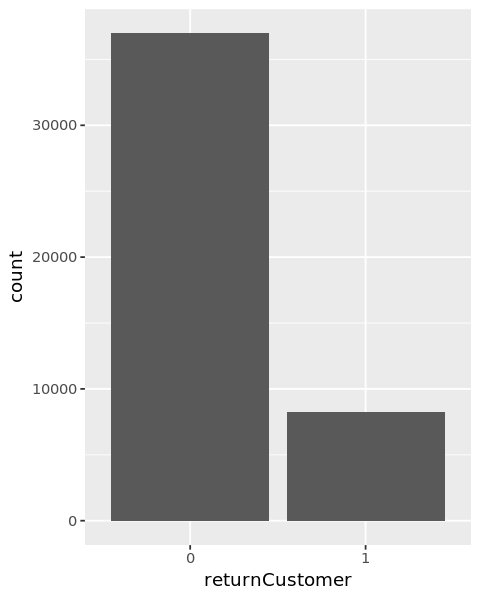

In [9]:
library(repr)
options(repr.plot.width=4, repr.plot.height=5)

ggplot(churnData, aes(x = returnCustomer)) + 
    geom_histogram(stat = "count") 

# __Основные этапы создания и выбора модели__
* Подготовка данных для последующего построения модели
* Спецификация модели (выбор параметров с использованием статистических гипотез)
* Интерпретация параметров и коэффициентов
* Оценка модели

## __Подготовка данных для последующего построения модели__
<pr>При обучение модели на имеющихся данных  основной проблемой является переобучение. При переобучении модель показывает отличные результаты на текущих данных, но не может обобщить основные тренды. В результате при использовании модели для анализа новых данных полученный результат будет примерно таким же как и у базовой модели (baseline model), согласно которой интересующие нас событие произойдет с вероятностью 50%.<pr>
    
<pr>Для того чтобы избежать переобучения нам необходимо разделить данные случайным образом на две части, одна из них будет так называемый training set на котором будет происходит обучение модели. Вторая часть test set служит для оценки нашей модели, как хорошо построенная модель способна предсказать интересующий нас показатель на новых данных. Данный подход называется Out-of-Sample Validation<pr>  

#### __Out-of-Sample Validation (разделение данных на две части training and test)__

In [10]:
# set.seed позволяет каждый раз воспроизводить компоненты сгенирированные случайным образом
set.seed(534381) 
 
# сгенирировать индексы случайным для training и test set 
trainIndex <- createDataPartition(churnData$returnCustomer,p=0.75,list=FALSE)

#разделить данные на training/testing set 
train <- churnData[trainIndex,] #training data (75% of data)
test <- churnData[-trainIndex,] #testing data (25% of data)

## __Спецификация модели (выбор параметров с использованием статистических гипотез)__

#### Модель построенная на основе всех параметров, информация о которых содержиться в данных, за исключением X + ID + orderDate

In [11]:
logitModelFull <- glm(returnCustomer ~ . -(X + ID + orderDate), family = binomial, train)

In [14]:
summary(logitModelFull) 


Call:
glm(formula = returnCustomer ~ . - (X + ID + orderDate), family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5932  -0.6615  -0.5652  -0.4457   2.3890  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -1.63522    0.07664 -21.337  < 2e-16 ***
titleMr                       0.20056    0.06047   3.317 0.000911 ***
titleMrs                      0.22364    0.06232   3.589 0.000332 ***
titleOthers                   0.76950    0.06607  11.647  < 2e-16 ***
newsletter1                   0.54731    0.03497  15.653  < 2e-16 ***
websiteDesign2               -0.36683    0.18661  -1.966 0.049322 *  
websiteDesign3               -0.17010    0.18220  -0.934 0.350496    
paymentMethodCredit Card     -0.21181    0.05656  -3.745 0.000181 ***
paymentMethodCurrent Account -0.17818    0.04847  -3.676 0.000237 ***
paymentMethodInvoice         -0.15472    0.04278  -3.617 0.000298 ***

## __Выбор параметров с использованием статистических гипотез__
Для выбора параметров будущей модели наиболее удобным и часто используемым инструментом является использование статистических гипотез. Если в результате тестирования статистической гипотезы, мы получаем значения появление которых (или еще более крайних) маловероятно (статистически значимый результат), то мы отвергаем нулевую гипотезу и приходим к выводу что в данном случае существует взаимосвязь (корреляция) между исследуемыми переменными.

<pr>__В качестве р-значения (уровня значимости) по умолчанию используется значение равное 0.05:__ Вероятность что коэффициента имеет данное значение составляет лишь 5%, если H0 Нулевая гипотеза (предположение о том, что нет никакой корреляции между независимой и зависимой переменными и коэффициент при независимой переменной равен нулю) верна.<pr>

<pr>__Статистические гипотезы:__ 
* H0 Нулевая гипотеза нет никакой в зависимости (корреляции) между независимой и зависимой переменными: Z-value = 0 
* H1 Гипотеза есть взаимосвязь (корреляция)между независимой зависимой переменными: Z-value = 17.280<pr>

<pr> если H0 Нулевая гипотеза верна тогда вероятность того, что значение Z-value будет равно 17.280 или будет больше составляет меньше 5%. Следовательно мы отказываемся от H0 Нулевой гипотезы, т.к. она является маловероятной и допускаем что существует корреляция между независимой и зависимой переменными.<pr>

<pr>__Пример:__ 
<br>__H0:__ Влияние данной переменной на невыплату текущего платежа равно нулю.

#### Модель построенная с учетом переменных, которые являются статистически значимыми на основе анализа полной модели

In [15]:
logitModelNew <- glm(returnCustomer ~ title + newsletter + websiteDesign + 
                     paymentMethod + couponDiscount + purchaseValue + throughAffiliate + 
                     shippingFees + dvd + blueray + vinyl + videogameDownload + 
                     prodOthers + prodRemitted, family = binomial, train)

In [16]:
summary(logitModelNew) 


Call:
glm(formula = returnCustomer ~ title + newsletter + websiteDesign + 
    paymentMethod + couponDiscount + purchaseValue + throughAffiliate + 
    shippingFees + dvd + blueray + vinyl + videogameDownload + 
    prodOthers + prodRemitted, family = binomial, data = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.591  -0.661  -0.565  -0.445   2.393  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -1.63709    0.07658 -21.378  < 2e-16 ***
titleMr                       0.19821    0.06045   3.279 0.001041 ** 
titleMrs                      0.22262    0.06232   3.572 0.000354 ***
titleOthers                   0.76716    0.06605  11.614  < 2e-16 ***
newsletter1                   0.54633    0.03496  15.627  < 2e-16 ***
websiteDesign2               -0.37360    0.18649  -2.003 0.045139 *  
websiteDesign3               -0.17502    0.18209  -0.961 0.336465    
paymentMethodCredit Card     -0.21591    0.0

## __Интерпретация параметров и коэффициентов__

In [17]:
coefsExp <- coef(logitModelNew) %>% exp() %>% round(2) 
print(coefsExp)

                 (Intercept)                      titleMr 
                        0.19                         1.22 
                    titleMrs                  titleOthers 
                        1.25                         2.15 
                 newsletter1               websiteDesign2 
                        1.73                         0.69 
              websiteDesign3     paymentMethodCredit Card 
                        0.84                         0.81 
paymentMethodCurrent Account         paymentMethodInvoice 
                        0.84                         0.86 
             couponDiscount1               purchaseValue2 
                        0.73                         0.85 
              purchaseValue3               purchaseValue4 
                        0.72                         0.78 
              purchaseValue5            throughAffiliate1 
                        0.94                         1.50 
               shippingFees1                         dvd

* покупатели, которые оформили подписку на рассылку, вероятнее всего совершит повторную покупку
* покупатели, которые воспользовались купоном вероятнее всего не вернуться
* покупатели у которых была бесплатная доставка вероятнее всего вернуться и совершать заказ вновь

## __Оценка модели__

### существующие методы оценки логистических моделей
* Альтернативные информационные критерии (Pseudo R2 Statistics)
* Матрица ошибок (Confusion Matrix)
* Точность модели (Accuracy)
* Перекрестная проверка модели

### __Альтернативные информационные критерии (Pseudo R2 Statistics)__
* McFadden
* Nagelkerke
* Cox & Snell

__Интерпретация альтернативных информационных критериев:__
* Приемлемый, если критерии > 0.2 
* Хороший, если критерии  > 0.4 
* Очень хороший, если критерии > 0.5 

In [18]:
LogRegR2(logitModelNew) 

Chi2                 1106.488 
Df                   32 
Sig.                 0 
Cox and Snell Index  0.03208769 
Nagelkerke Index     0.05227661 
McFadden's R2        0.03427924 

### __Матрица ошибок (Confusion Matrix)__

#### Предсказанное значение вероятности, что клиент либо посетит вновь, либо больше не посетит интернет-магазин

In [19]:
test$predNew <- predict(logitModelNew, type = "response", newdata = test, na.action = na.exclude) 

test %>% select(returnCustomer, predNew) %>% tail() 

,returnCustomer,predNew
45212,0,0.1017566
45225,0,0.1163592
45227,0,0.1320433
45230,1,0.2670244
45233,1,0.2584148
45236,0,0.3213470


#### построение матрицы ошибок на основе предсказанных значений вероятности

In [20]:
confMatrixNew <- confusion.matrix(test$returnCustomer, test$predNew,  
                 threshold = 0.3) 
confMatrixNew 

    obs
pred    0    1
   0 8693 1800
   1  548  268
attr(,"class")
[1] "confusion.matrix"

### __Точность модели (Accuracy)__

In [21]:
accuracyNew <- sum(diag(confMatrixNew)) / sum(confMatrixNew) 
accuracyNew 

[1] 0.7923778

### __Перекрестная проверка модели__

Перекрёстная проверка(скользящий контроль, англ. cross-validation) это метод оценки аналитической модели и её поведения на независимых данных. При оценке модели имеющиеся в наличии данные разбиваются на k частей. Затем на k−1 частях данных производится обучение модели, а оставшаяся часть данных используется для тестирования. Процедура повторяется k раз; в итоге каждая из k частей данных используется для тестирования. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных. 

#### Построение и перекрестная проверка модели при помощи caret package. 
В данном случае значение k равно 5 (наиболее часто используемое значение на практике), т.е тренировка производится на 4 частях данных, оставшаяся часть используется для проверки модели

In [22]:
model <- train(returnCustomer ~ title + newsletter + websiteDesign + 
               paymentMethod + couponDiscount + purchaseValue + throughAffiliate + 
               shippingFees + dvd + blueray + vinyl + videogameDownload + 
               prodOthers + prodRemitted, data = train, method = "glm",
               trControl = trainControl(method = "cv", number = 5, verboseIter= TRUE))

+ Fold1: parameter=none 
- Fold1: parameter=none 
+ Fold2: parameter=none 
- Fold2: parameter=none 
+ Fold3: parameter=none 
- Fold3: parameter=none 
+ Fold4: parameter=none 
- Fold4: parameter=none 
+ Fold5: parameter=none 
- Fold5: parameter=none 
Aggregating results
Fitting final model on full training set


In [27]:
print(model$results)

  parameter  Accuracy       Kappa   AccuracySD     KappaSD
1      none 0.8170484 0.007329292 0.0002580624 0.001656689


## Вывод:
в данном примере был произведен анализ от каких факторов зависит отток клиентов и построена модель для построения прогноза оттока для текущих и абсолютно новых данных. Данная регрессионная модель способна предсказывать вероятность оттока клиентов с точностью 81,7%. На практике это позволит компании провести различные мероприятия по удержанию клиентов и внести изменения в систему взаимоотношениями с клиентами.